Average skill ratings by department:
                   ML        DL    Python  Statistics  Data Wrangling  \
Department                                                             
0           6.235294  4.735294  5.058824    5.705882        5.117647   
1           0.000000  0.000000  0.000000    0.000000        0.000000   
2           0.000000  0.000000  0.000000    0.000000        0.000000   
3           0.000000  0.000000  0.000000    0.000000        0.000000   
4           0.000000  0.000000  5.441176    0.000000        0.000000   

                   R      Java       C++  Algorithms  Data Structures  ...  \
Department                                                             ...   
0           5.941176  0.000000  0.000000    0.000000         0.000000  ...   
1           0.000000  0.000000  0.000000    0.000000         0.000000  ...   
2           0.000000  0.000000  0.000000    0.000000         0.000000  ...   
3           0.000000  0.000000  0.000000    0.000000         0.0000

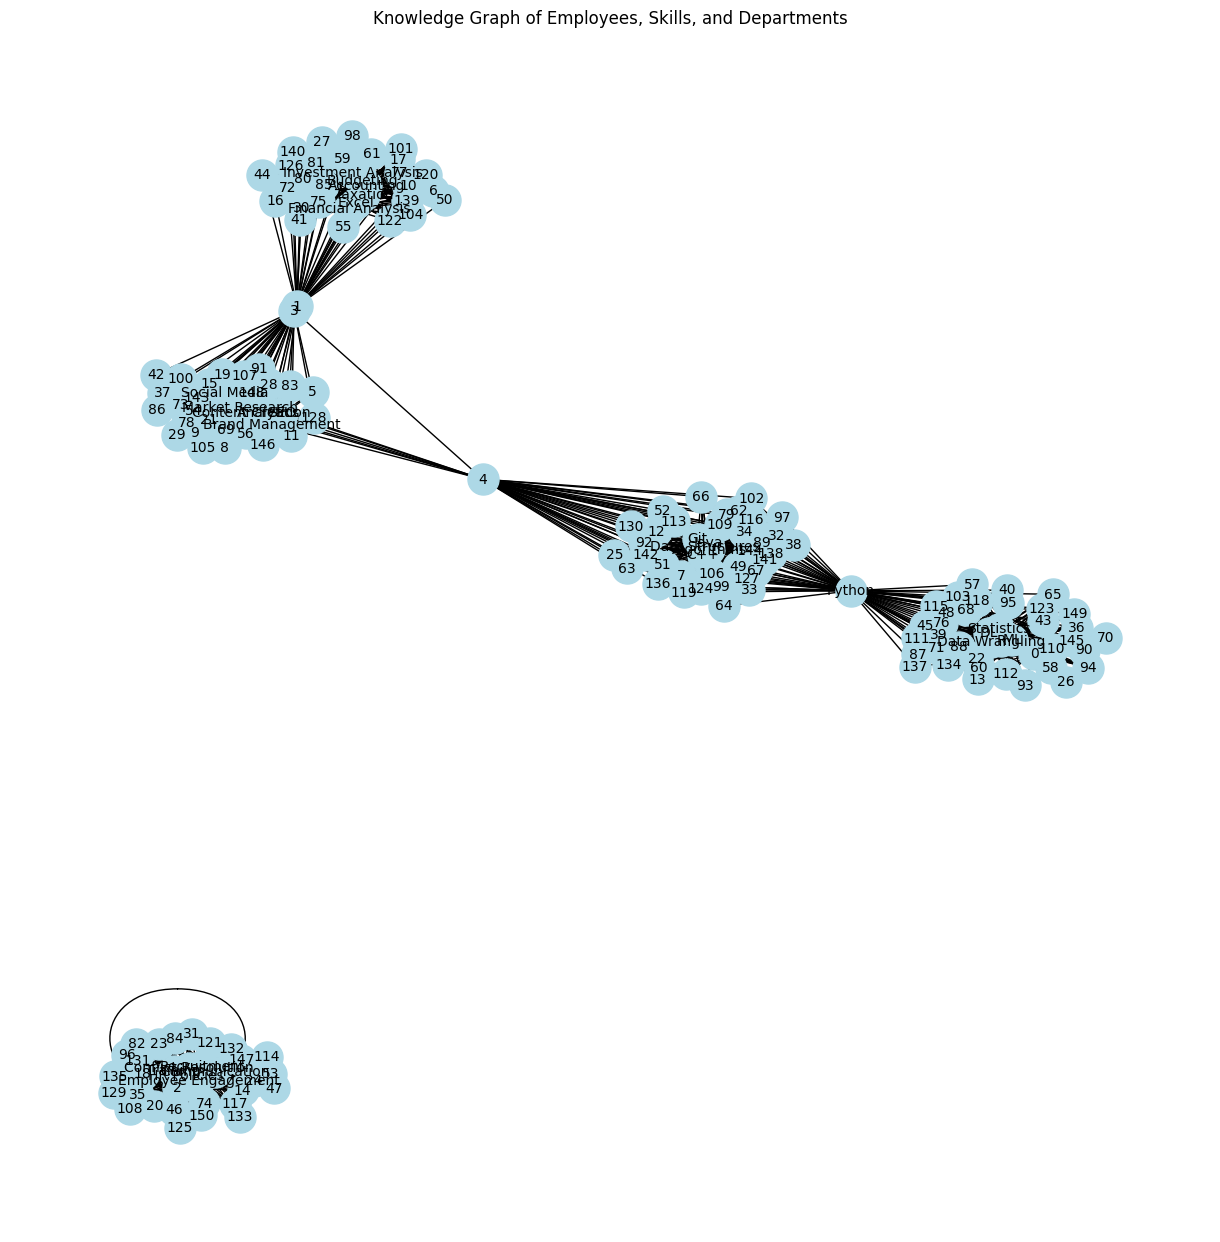

Computing transition probabilities:   0%|          | 0/180 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/183 [00:00<?, ?it/s]

Predicted Department: Data Science
Matching Skills for Department Data Science: ['ML', 'DL', 'Python', 'Excel']
Missing Skills for Department Data Science: ['Statistics', 'Data Wrangling', 'R', 'Java', 'C++', 'Algorithms', 'Data Structures', 'Git', 'Recruitment', 'Training', 'Communication', 'Conflict Resolution', 'Employee Engagement', 'HR Policies', 'SEO', 'Content Creation', 'Analytics', 'Social Media', 'Brand Management', 'Market Research', 'Accounting', 'Financial Analysis', 'Budgeting', 'Taxation', 'Investment Analysis']
Skills to Improve for Department Data Science: {}


In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from node2vec import Node2Vec

# Load the dataset
file_path = 'employee_skills_ratings_V3.csv'
df = pd.read_csv(file_path)

# Encode the department labels to integers
label_encoder = LabelEncoder()
df['Department'] = label_encoder.fit_transform(df['Department'])

# Calculate the average rating for each skill within each department
department_skill_averages = df.groupby('Department').mean().drop(columns=['Employee ID'])
print("Average skill ratings by department:\n", department_skill_averages)

# Identify relevant skills for each department (skills with non-zero average ratings)
relevant_skills = department_skill_averages.apply(lambda x: x[x > 0].index.tolist(), axis=1)
print("\nRelevant skills for each department:\n", relevant_skills)

# Initialize the graph
G = nx.Graph()

# Add nodes and edges to the graph
for index, row in df.iterrows():
    employee_id = row['Employee ID']
    department = row['Department']
    skills = row.drop(['Employee ID', 'Department'])

    # Add employee node
    G.add_node(employee_id, type='employee')

    # Add department node and edge
    G.add_node(department, type='department')
    G.add_edge(employee_id, department, weight=1)

    # Add skill nodes and edges
    for skill, rating in skills.items():
        if rating > 0:
            G.add_node(skill, type='skill')
            G.add_edge(employee_id, skill, weight=rating)

# Draw the knowledge graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10)
plt.title('Knowledge Graph of Employees, Skills, and Departments')
plt.show()

# Generate embeddings using Node2Vec
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Prepare data for department prediction
X = np.array([model.wv[str(employee_id)] for employee_id in df['Employee ID']])
y = df['Department']

# Train a classifier on the embeddings
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X, y)

# Function to predict the most appropriate department
def predict_department(new_skills):
    # Create a temporary new employee node with the given skills
    new_employee_id = 'new_employee'
    G.add_node(new_employee_id, type='employee')
    for skill, rating in new_skills.items():
        if rating > 0:
            G.add_edge(new_employee_id, skill, weight=rating)

    # Re-train the Node2Vec model to include the new node
    node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
    model = node2vec.fit(window=10, min_count=1, batch_words=4)

    # Generate embedding for the new employee
    new_employee_emb = model.wv[new_employee_id].reshape(1, -1)

    # Predict the department
    predicted_department = rf_clf.predict(new_employee_emb)[0]

    # Remove the temporary node from the graph
    G.remove_node(new_employee_id)

    return predicted_department

# Function to suggest missing, needed, and matching skills
def analyze_skills(new_skills, predicted_department, avg_ratings):
    relevant_skills = avg_ratings.loc[predicted_department]
    missing_skills = []
    needed_skills = {}
    matching_skills = []

    for skill, avg_rating in relevant_skills.items():
        if skill not in new_skills or new_skills[skill] == 0:
            missing_skills.append(skill)
        elif new_skills[skill] < avg_rating:
            needed_skills[skill] = avg_rating - new_skills[skill]
        else:
            matching_skills.append(skill)

    return matching_skills, missing_skills, needed_skills

# Example: Predict department for a new individual and analyze skills
new_individual_skills = {
    'ML': 8,
    'DL': 7,
    'Python': 9,
    'Java': 0,
    'Excel': 5,
    'SQL': 4,
    'Data Analysis': 6,
    'Finance': 0,
    'Marketing': 0,
    'Product Management': 0,
    'Networking': 0,
    'Cloud Computing': 0
}

predicted_dept = predict_department(new_individual_skills)
predicted_dept_label = label_encoder.inverse_transform([predicted_dept])[0]  # Convert department ID back to label
print(f"Predicted Department: {predicted_dept_label}")

matching_skills, missing_skills, needed_skills = analyze_skills(new_individual_skills, predicted_dept, department_skill_averages)
print(f"Matching Skills for Department {predicted_dept_label}: {matching_skills}")
print(f"Missing Skills for Department {predicted_dept_label}: {missing_skills}")
print(f"Skills to Improve for Department {predicted_dept_label}: {needed_skills}")


In [4]:
# !pip install node2vec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.0 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.3
    Uninstalling networkx-3.3:
      Successfully uninstalled networkx-3.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.